# 01 — Preprocessing & EDA (Beijing Multi-Site Air Quality)
Mục tiêu: tải dữ liệu, làm sạch, tạo nhãn phân lớp (AQI class theo PM2.5 24h mean), tạo đặc trưng thời gian + lag, và lưu `data/processed/cleaned.parquet`.

**Lưu ý:** nếu `USE_UCIMLREPO=True` thì notebook cần internet để tải dataset từ UCI.

In [1]:
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"

OUTPUT_CLEANED_PATH = 'data/processed/cleaned.parquet'
LAG_HOURS=[1, 3, 24]


In [2]:
# Parameters
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
OUTPUT_CLEANED_PATH = "data/processed/cleaned.parquet"
LAG_HOURS = [1, 3, 24]


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_pm25_24h_and_label,
    add_time_features,
    add_lag_features,
)

PROJECT_ROOT = Path('..').resolve()
OUT_PATH = (PROJECT_ROOT / OUTPUT_CLEANED_PATH).resolve()
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)


In [4]:
df_raw = load_beijing_air_quality(use_ucimlrepo=USE_UCIMLREPO, raw_zip_path=RAW_ZIP_PATH)
print('raw shape:', df_raw.shape)
df_raw.head()

raw shape: (420768, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
df = clean_air_quality_df(df_raw)
df = add_pm25_24h_and_label(df)
df = add_time_features(df)
df = add_lag_features(df, lag_hours=LAG_HOURS)
print('cleaned shape:', df.shape)
df[['datetime','station','PM2.5','pm25_24h','aqi_class']].head(10)

cleaned shape: (420768, 55)


,datetime,station,PM2.5,pm25_24h,aqi_class
0,2013-03-01 00:00:00,Aotizhongxin,4.0,NaN,NaN
1,2013-03-01 01:00:00,Aotizhongxin,8.0,NaN,NaN
2,2013-03-01 02:00:00,Aotizhongxin,7.0,NaN,NaN
3,2013-03-01 03:00:00,Aotizhongxin,6.0,NaN,NaN
4,2013-03-01 04:00:00,Aotizhongxin,3.0,NaN,NaN
5,2013-03-01 05:00:00,Aotizhongxin,5.0,NaN,NaN
6,2013-03-01 06:00:00,Aotizhongxin,3.0,NaN,NaN
7,2013-03-01 07:00:00,Aotizhongxin,3.0,NaN,NaN
8,2013-03-01 08:00:00,Aotizhongxin,3.0,NaN,NaN
9,2013-03-01 09:00:00,Aotizhongxin,3.0,NaN,NaN


In [6]:
# Q1.1.1 Kiểm tra khoảng thời gian dữ liệu phủ (start/end)
df['datetime'].min(), df['datetime'].max()

# Q1.1.2 Kiểm tra tần suất theo giờ và tính liên tục (theo 1 station mẫu)
sample_station = df['station'].iloc[0]
df_station = df[df['station'] == sample_station].set_index('datetime')

# Tần suất theo giờ
pd.infer_freq(df_station.index)

# Kiểm tra số mốc giờ bị thiếu
full_index = pd.date_range(
    start=df_station.index.min(),
    end=df_station.index.max(),
    freq='H'
)

len(full_index.difference(df_station.index))

0

<Axes: title={'center': 'Monthly missing rate of PM2.5'}, xlabel='datetime'>

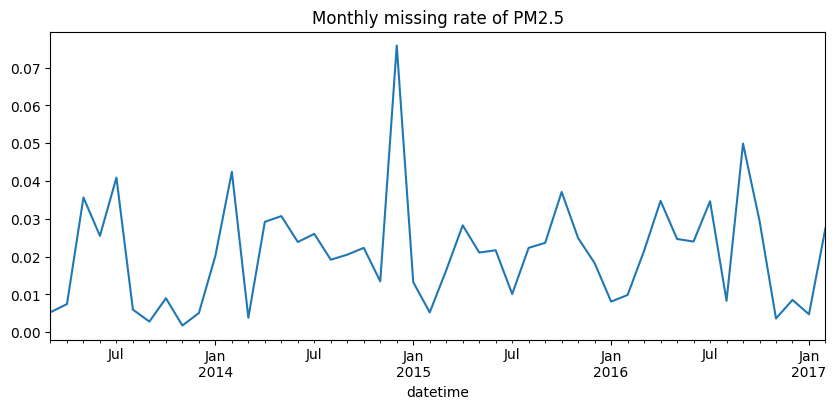

In [7]:
# Q1.2.1: Tỷ lệ thiếu theo biến
# EDA nhanh: missingness và phân bố lớp
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate.head(20)

# Q1.2.2 Thiếu dữ liệu PM2.5 theo thời gian
df.set_index('datetime')['PM2.5'].isna().resample('M').mean().plot(
    figsize=(10,4),
    title='Monthly missing rate of PM2.5'
)

<Axes: >

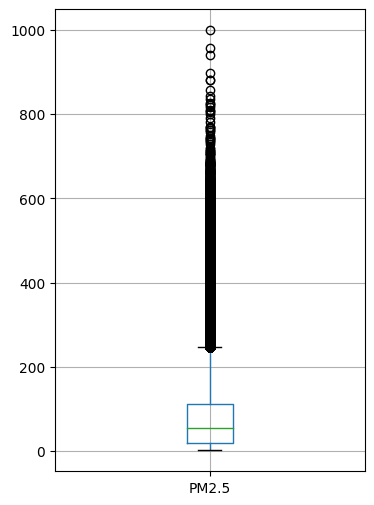

In [8]:
# Q1.3 Dùng boxplot hoặc quantile để nhìn nhanh ngoại lai (outliers) và phân phối lệch.
df['PM2.5'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
df[['PM2.5']].boxplot(figsize=(4,6))

<Axes: title={'center': 'PM2.5 (Zoomed 1–2 months)'}, xlabel='datetime'>

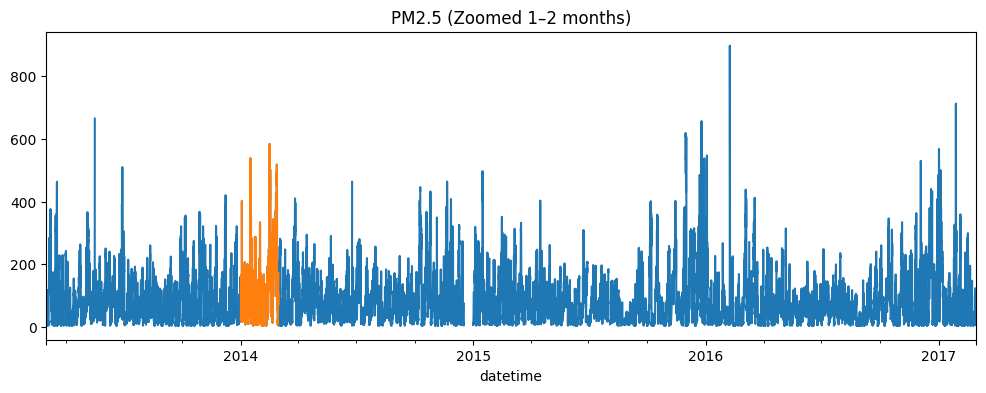

In [9]:
# Q1.4: Vẽ chuỗi PM2.5 theo thời gian
df_station['PM2.5'].plot(
    figsize=(12,4),
    title=f'PM2.5 over time - station {sample_station}'
)

# Phóng to 1–2 tháng
df_station.loc['2014-01':'2014-02','PM2.5'].plot(
    figsize=(12,4),
    title='PM2.5 (Zoomed 1–2 months)'
)

In [10]:
# Q1.5: Tự tương quan với các độ trễ 24h & 168h
df_station['PM2.5'].corr(df_station['PM2.5'].shift(24)), \
df_station['PM2.5'].corr(df_station['PM2.5'].shift(168))

(0.3940510996529193, 0.01811568783444313)

In [11]:
# Q1.6: Kiểm tra tính dừng (ADF / KPSS)
from statsmodels.tsa.stattools import adfuller, kpss

series = df_station['PM2.5'].dropna()

adf_result = adfuller(series)
kpss_result = kpss(series, regression='c')

adf_result, kpss_result


C:\Users\Admin\AppData\Local\Temp\ipykernel_12260\1276639460.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')


((-19.52613859569152,
  0.0,
  39,
  34099,
  {'1%': -3.4305417883908857,
   '5%': -2.8616247656588847,
   '10%': -2.566815118108384},
  303175.95117858925),
 (0.2008054666300104,
  0.1,
  105,
  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}))

In [12]:
class_dist = df['aqi_class'].value_counts(dropna=False)
class_dist

aqi_class
Unhealthy                         148558
Moderate                          109549
Unhealthy_for_Sensitive_Groups     64731
Very_Unhealthy                     56242
Hazardous                          19931
Good                               13924
NaN                                 7833
Name: count, dtype: int64

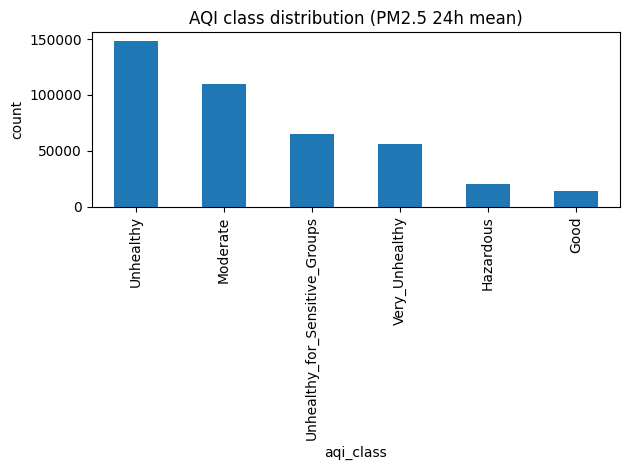

In [13]:
import matplotlib.pyplot as plt

class_dist.drop(index=[x for x in class_dist.index if pd.isna(x)], errors='ignore').plot(kind='bar')
plt.title('AQI class distribution (PM2.5 24h mean)')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [14]:
df.to_parquet(OUT_PATH, index=False)
print('Saved:', OUT_PATH)

Saved: D:\ki2nam4\datamining\data\processed\cleaned.parquet
